In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# function for generating op dataset
def generate_op_data(dataset_size, op_size, prize_type='const'):
    depot = np.random.uniform(size=(dataset_size, 2))
    loc = np.random.uniform(size=(dataset_size, op_size, 2))

    # Methods taken from Fischetti et al. 1998
    if prize_type == 'const':
        prize = np.ones((dataset_size, op_size))
    elif prize_type == 'unif':
        prize = (1 + np.random.randint(0, 100, size=(dataset_size, op_size))) / 100.
    else:  # Based on distance to depot
        assert prize_type == 'dist'
        prize_ = np.linalg.norm(depot[:, None, :] - loc, axis=-1)
        prize = (1 + (prize_ / prize_.max(axis=-1, keepdims=True) * 99).astype(int)) / 100.

    # Max length is approximately half of optimal TSP tour, such that half (a bit more) of the nodes can be visited
    # which is maximally difficult as this has the largest number of possibilities
    MAX_LENGTHS = {
        20: 2.,
        50: 3.,
        100: 4.
    }

    return depot, loc, prize, np.full(dataset_size, MAX_LENGTHS[op_size])  # Capacity, same for whole dataset

In [3]:
# generate op data
depot, loc, prize, max_length = generate_op_data(10000, 20)

In [4]:
loc[0].shape

(20, 2)

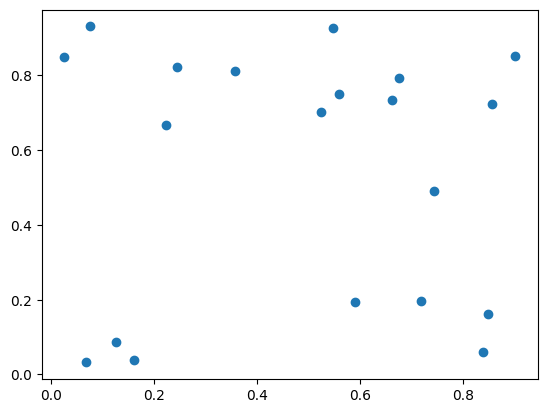

In [5]:
# plot an op graph
plt.plot(loc[0][:, 0], loc[0][:, 1], 'o')